# Explore here

### **Exploratory Data Analysis (EDA)**

#### **Importing Libraries**

In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import json
from sklearn.model_selection import train_test_split
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

#### **Problem statement and data collection**

In [86]:
total_data = pd.read_csv("../data/raw/imdb_top_1000.csv")
total_data.head(3)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


#### **Exploration and data cleaning**

**Understanding the features**

- **PosterLink:** Link of the poster that imdb using

- **SeriesTitle:** Name of the movie

- **ReleasedYear:** Year at which that movie released

- **Certificate:** Certificate earned by that movie

- **Runtime:** Total runtime of the movie

- **Genre:** Genre of the movie

- **IMDB Rating:** Rating of the movie at IMDB site

- **Overview:** mini story/ summary

- **Meta_score:** Score earned by the movie

- **Director:** Name of the Director

- **Star1,Star2,Star3,Star4:** Name of the Stars

- **No of votes:** Total number of votes

- **Gross:** Money earned by that movie

In [87]:
print('The dataframe contains {} rows and it has {} features.'.format(len(total_data), total_data.shape[1]))

The dataframe contains 1000 rows and it has 16 features.


In [88]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


Dataset Overview and Analysis

- **Core Features Are Complete**
Essential columns for a content-based recommender are fully populated: **Series_Title**, **Genre**, **IMDB_Rating**, **Overview**, **Director**, and **Star1–Star4**.
Columns like **Certificate**, **Meta_score**, and **Gross** contain missing values and are optional for basic recommendations.

- **Data Types and Conversions Needed**
**Released_Year** should be converted to integer.
**Runtime** is currently a string; extract numeric minutes if needed.
**Gross** can be cleaned and converted to numeric if ranking by revenue is desired.



- **Recommended Columns for Content-Based Similarity**
**Genres + Director + Actors** → categorical similarity.
**Overview** → semantic similarity via TF-IDF or embeddings.
**IMDB_Rating and No_of_Votes** → for ranking and filtering popular movies.



- **Columns Useful for UI / Display**
**Poster_Link** → display movie posters in the Flask app.
**Certificate** → optional filtering by age rating.


**Overall Assessment**

The dataset is clean, manageable (1,000 rows), and well-suited for building a content-based movie recommender.
Minimal preprocessing is required to handle numeric conversions and optional missing values.

#### **Eliminate duplicates and nulls**

In [89]:
total_data = total_data.drop_duplicates(subset=['Series_Title'], keep='first')

In [90]:
critical_cols = ['Series_Title', 'Genre', 'Overview']

total_data = total_data.dropna(subset=critical_cols)

print(total_data[critical_cols].isna().sum())
print("Shape after dropping critical nulls:", total_data.shape)


Series_Title    0
Genre           0
Overview        0
dtype: int64
Shape after dropping critical nulls: (999, 16)


#### **Eliminate irrelevant information**

In [91]:
columns_to_drop = ['Poster_Link', 'Certificate', 'Gross', 'Runtime', 'Star3', 'Star4']
                   
total_data = total_data.drop(columns=columns_to_drop)

In [92]:
clean_data = total_data.copy()
clean_data.head(3)

,Series_Title,Released_Year,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,No_of_Votes
0,The Shawshank Redemption,1994,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,2343110
1,The Godfather,1972,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,1620367
2,The Dark Knight,2008,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,2303232


### **Analysis of univariate variables**

##### **Categorical Variables - Analysis**

In [93]:
categorical_variables = clean_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Variables:", categorical_variables)

Categorical Variables: ['Series_Title', 'Released_Year', 'Genre', 'Overview', 'Director', 'Star1', 'Star2']


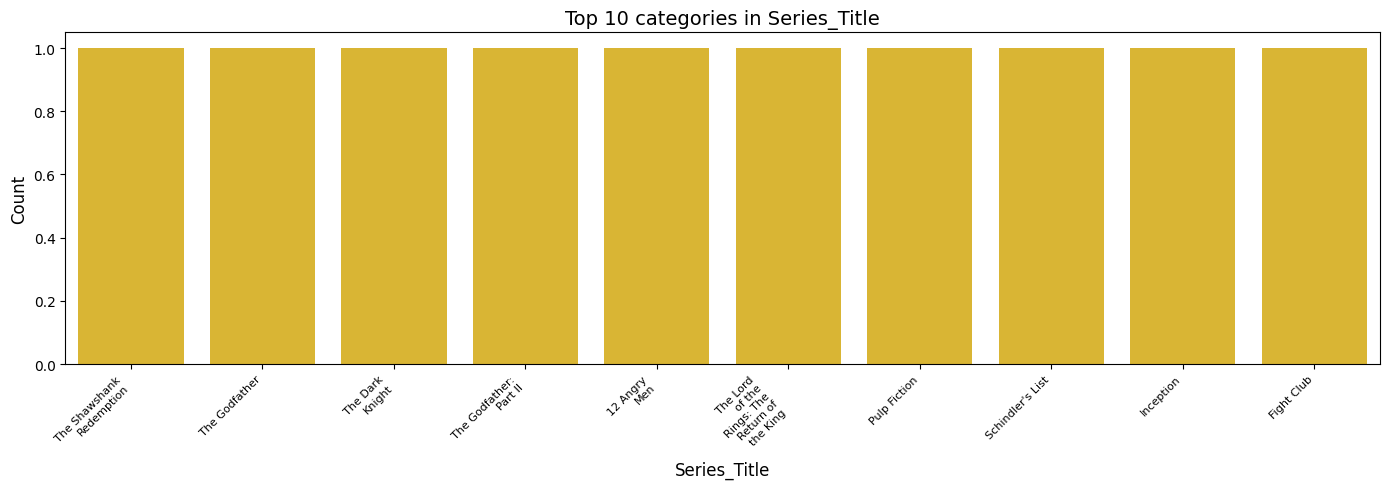

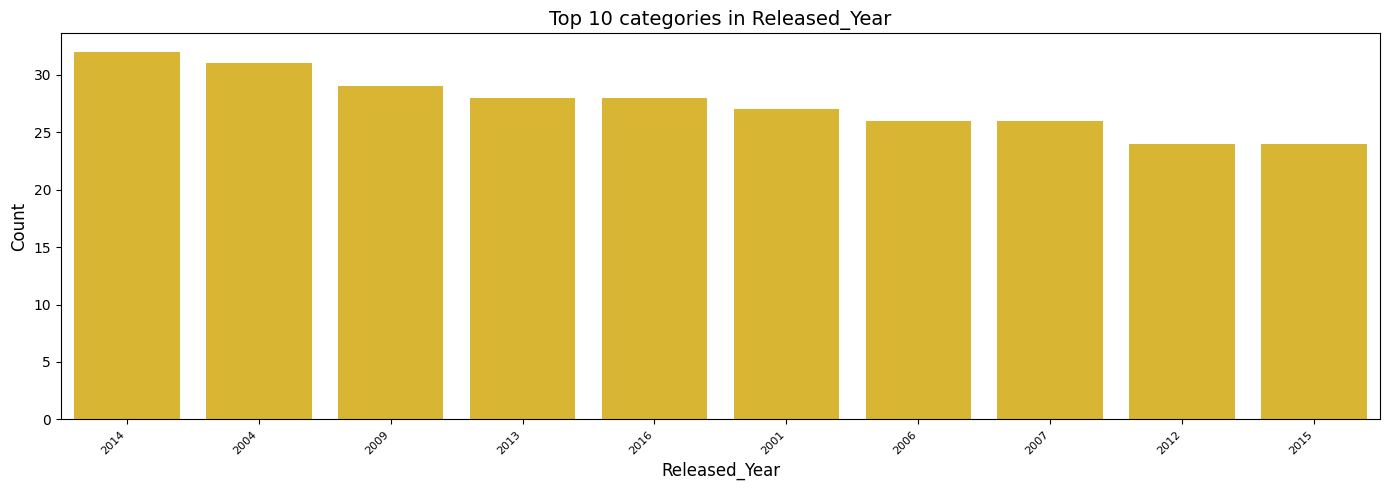

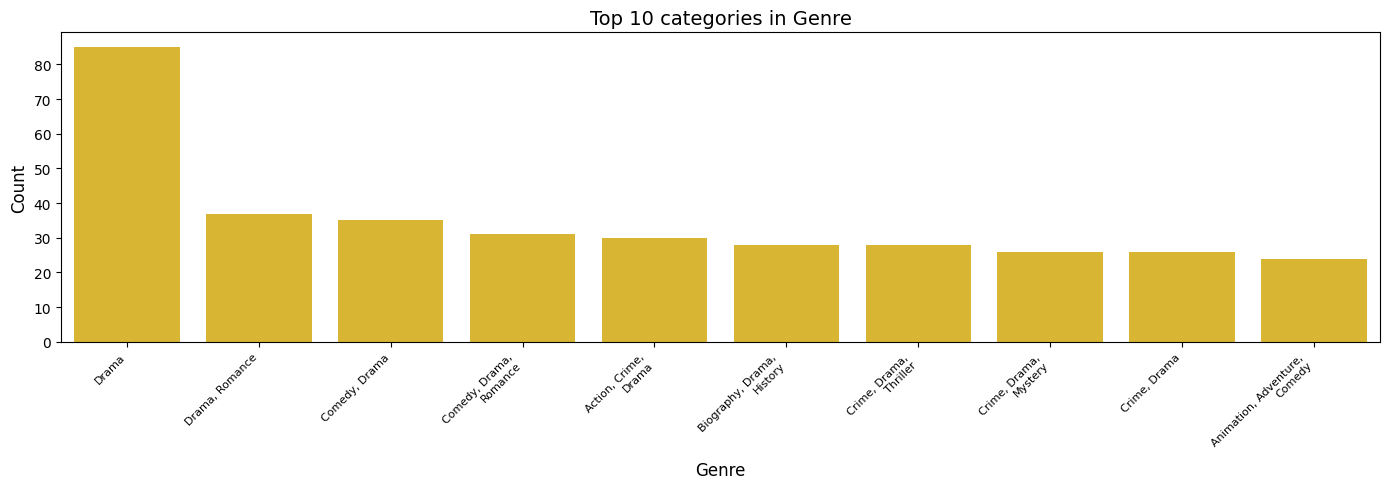

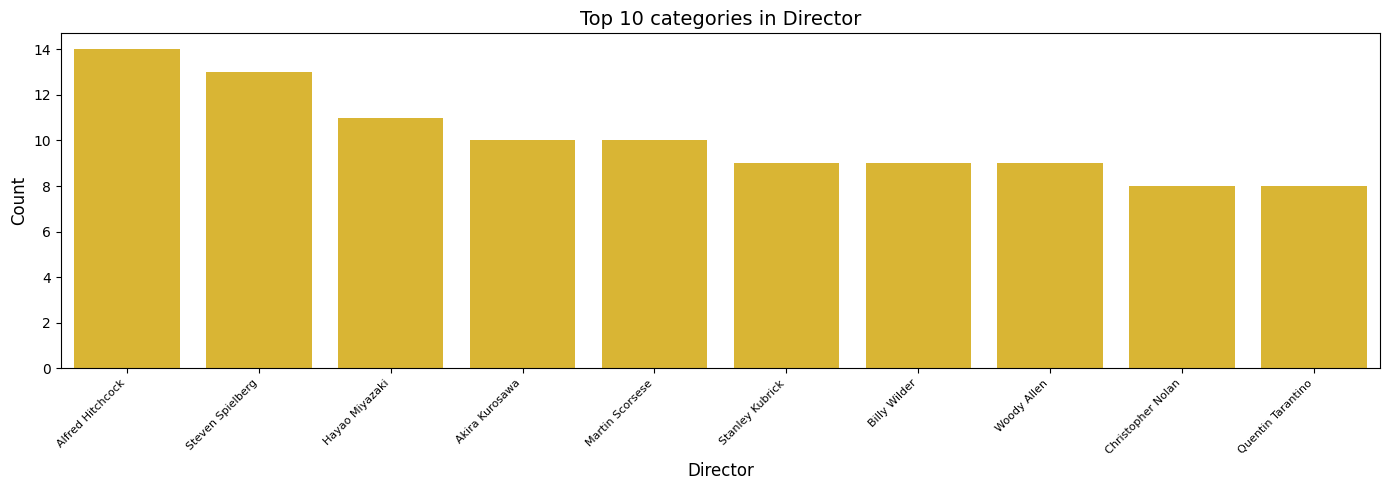

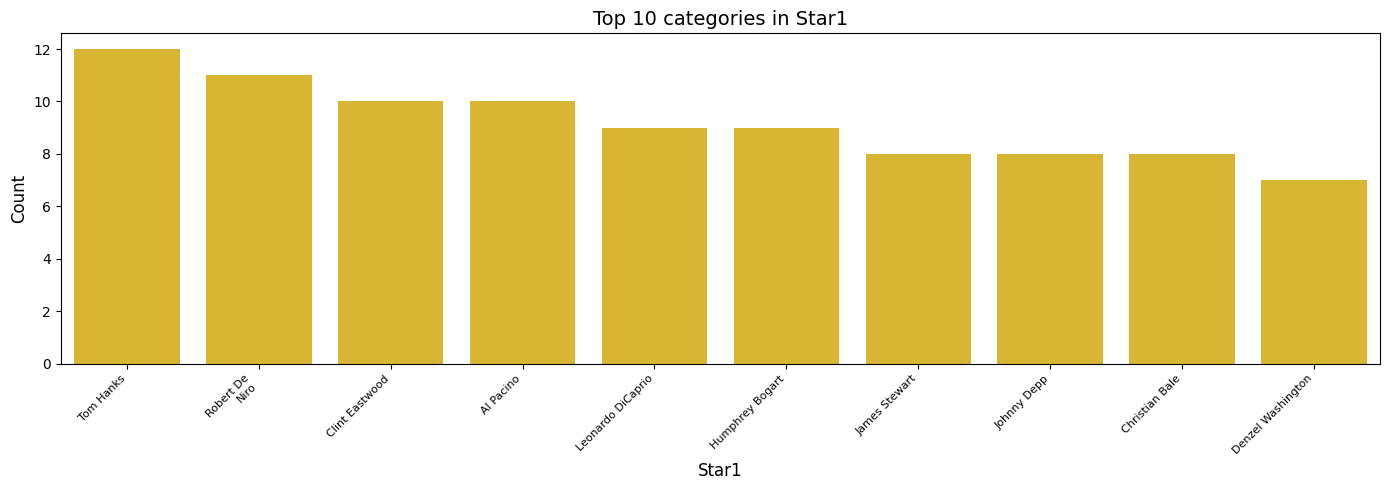

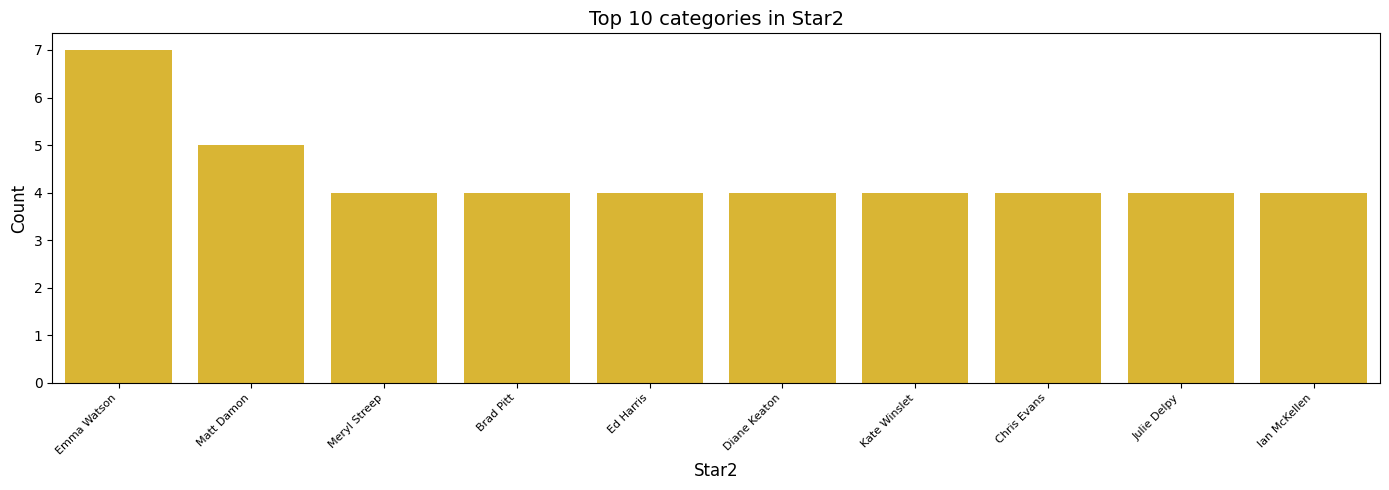

In [60]:
def split_label_by_words(label, words_per_line=2):
    words = label.split()
    lines = [' '.join(words[i:i+words_per_line]) for i in range(0, len(words), words_per_line)]
    return '\n'.join(lines)


for col in categorical_variables:
    if col == 'Overview':  
        continue
    
    plt.figure(figsize=(14,5))
    
    value_counts = clean_data[col].value_counts().head(10)
    
    labels = [split_label_by_words(l, words_per_line=2) for l in value_counts.index]
    
    sns.barplot(x=value_counts.index, y=value_counts.values, color='#F5C518')
    

    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=10)
    
    plt.title(f"Top 10 categories in {col}", fontsize=14)
    plt.ylabel("Count", fontsize=12)
    plt.xlabel(col, fontsize=12)
    
    plt.tight_layout()
    plt.show()


##### **Numerical Variables - Analysis**

In [94]:
numerical_variables = clean_data.select_dtypes(include=['number']).columns.tolist()
print("Numerical Variables:", numerical_variables)

Numerical Variables: ['IMDB_Rating', 'Meta_score', 'No_of_Votes']


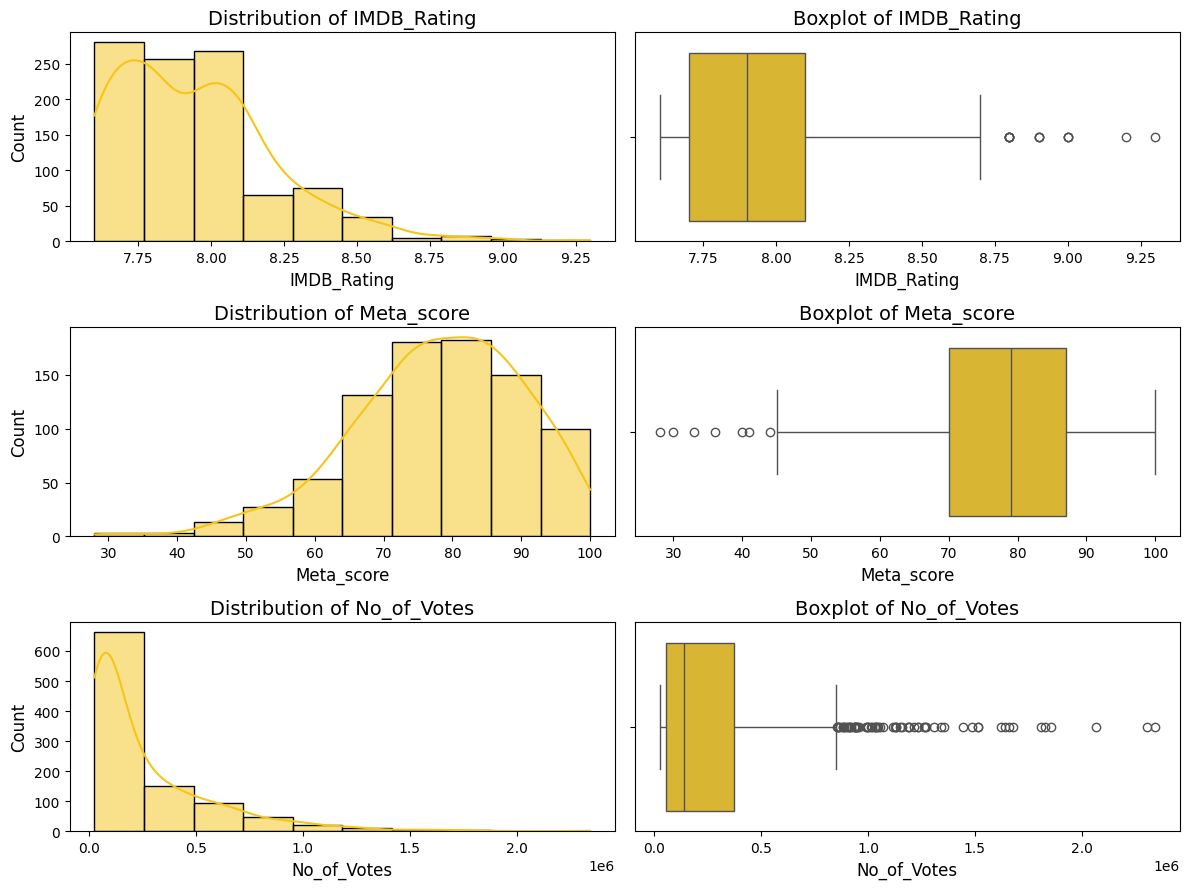

In [95]:
fig, axes = plt.subplots(nrows=len(numerical_variables), ncols=2, figsize=(12, 9))

for i, col in enumerate(numerical_variables):
    # Histogram
    sns.histplot(clean_data[col], bins=10, kde=True, color='#F5C518', ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {col}", fontsize=14)
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel("Count", fontsize=12)
    
    # Boxplot
    sns.boxplot(x=clean_data[col], color='#F5C518', ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {col}", fontsize=14)
    axes[i, 1].set_xlabel(col, fontsize=12)
    axes[i, 1].set_ylabel("")
    
plt.tight_layout()
plt.show()



**Overview**

The numerical analysis shows that the dataset is skewed toward high ratings, with a small number of exceptionally highly rated movies. This insight can guide the ranking or filtering logic in a content-based recommendation system.


##### **Multivariate Analysis**

**- Categorical vs Categorical Analysis**

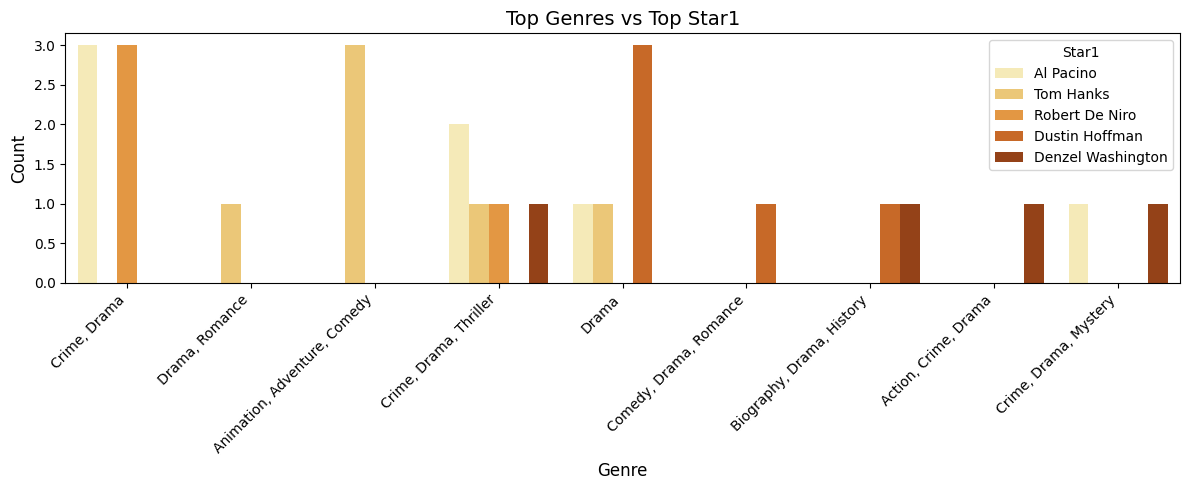

In [ ]:
# Top 10 genres
top_genres = clean_data['Genre'].value_counts().nlargest(10).index
filtered_data = clean_data[clean_data['Genre'].isin(top_genres)]

# Top 5 principal star
top_stars = filtered_data['Star1'].value_counts().nlargest(5).index
filtered_data = filtered_data[filtered_data['Star1'].isin(top_stars)]

plt.figure(figsize=(12,5))
sns.countplot(x='Genre', hue='Star1', data=filtered_data, palette='YlOrBr')
plt.title("Top Genres vs Top Star1", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Genre", fontsize=12)
plt.tight_layout()
plt.show()


 **- Numerical vs Numerical Analysis**

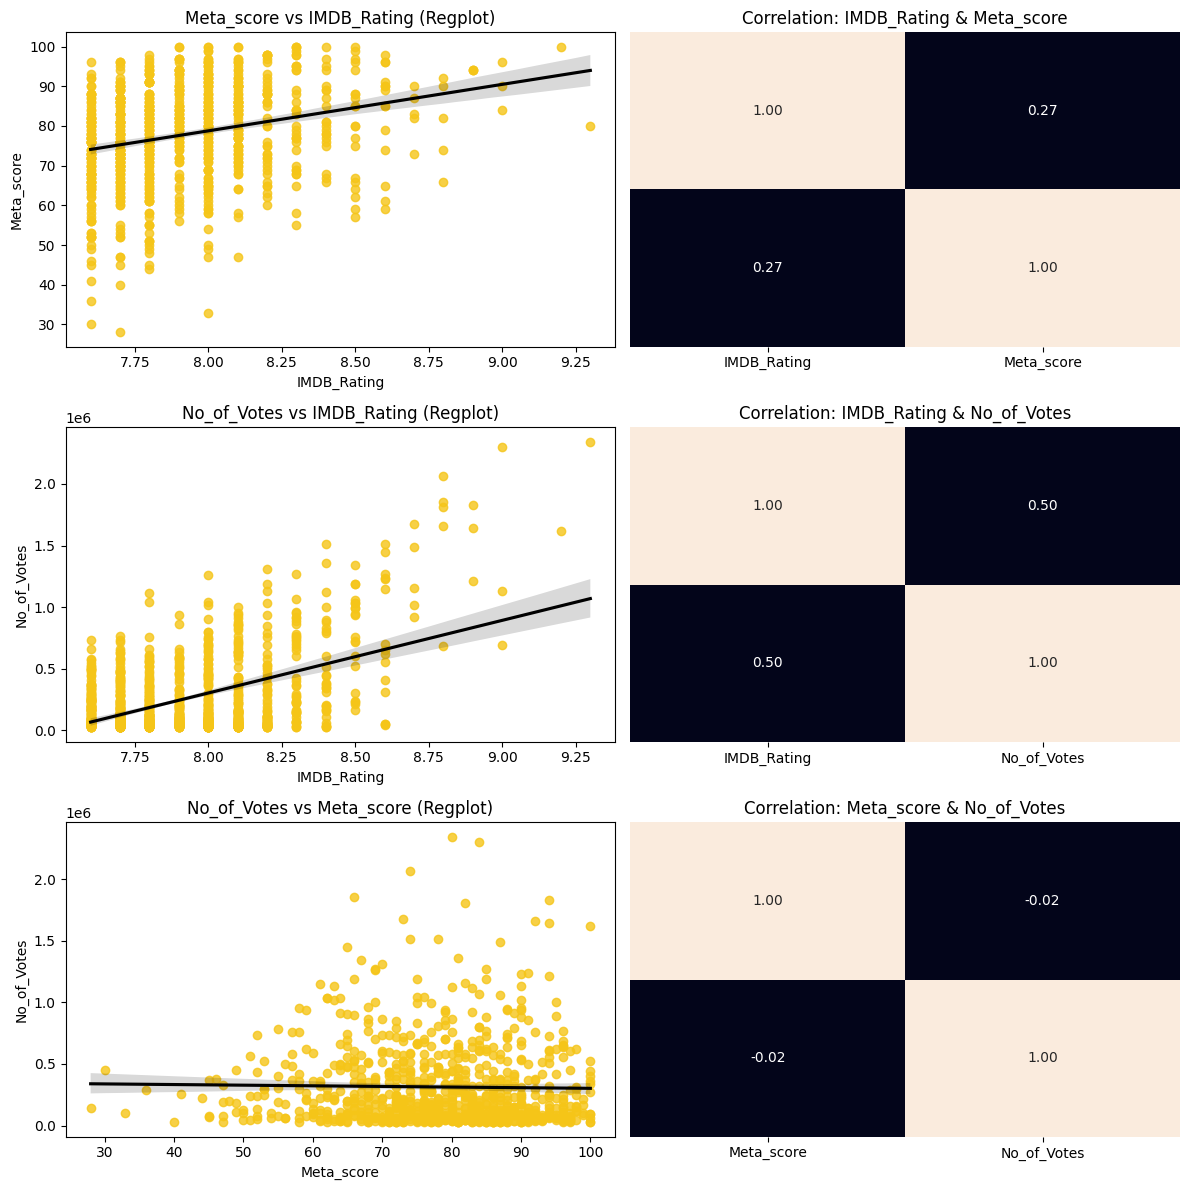

In [108]:
pairs = list(combinations(numerical_variables, 2))

n_pairs = len(pairs)
nrows = n_pairs
ncols = 2

fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*4))

for i, (x, y) in enumerate(pairs):
    # Regplot
    sns.regplot(ax=axis[i, 0], data=clean_data, x=x, y=y,
                scatter_kws={'color':'#F5C518'}, line_kws={'color':'#000000'})
    axis[i, 0].set_title(f"{y} vs {x} (Regplot)", fontsize=12)
    
    # Heatmap
    sns.heatmap(clean_data[[x, y]].corr(), annot=True, fmt=".2f",
                ax=axis[i, 1], cbar=False)
    axis[i, 1].set_title(f"Correlation: {x} & {y}", fontsize=12)
    axis[i, 1].set_yticks([])  

plt.tight_layout()
plt.show()


**Overview**

**- Numerical vs. Categorical Analysis**

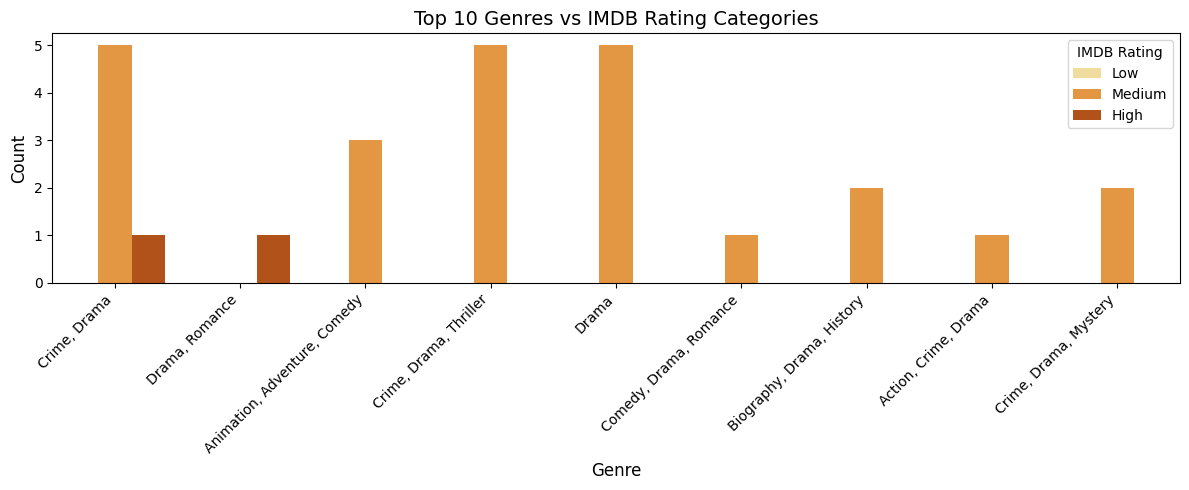

In [117]:
# Discretizar IMDB_Rating en 3 categorías
bins = [0, 6.5, 8.5, 10]
labels = ['Low', 'Medium', 'High']
filtered_data['IMDB_Category'] = pd.cut(filtered_data['IMDB_Rating'], bins=bins, labels=labels)

plt.figure(figsize=(12,5))
sns.countplot(x='Genre', hue='IMDB_Category', data=filtered_data, palette='YlOrBr')
plt.title("Top 10 Genres vs IMDB Rating Categories", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Genre", fontsize=12)
plt.legend(title='IMDB Rating', fontsize=10)
plt.tight_layout()
plt.show()


##### **Correlations Analysis**

In [121]:
categorical_f_rules = {}

for col in categorical_variables:
    encoded_col = f"{col}_n"
    clean_data[encoded_col], uniques = pd.factorize(clean_data[col])
    dicc = dict(zip(uniques, range(len(uniques))))
    categorical_f_rules[col] = dicc

with open("categorical_rules.json", "w") as f:
    json.dump(categorical_f_rules, f)

with open("categorical_rules.json", "r") as f:
    loaded_mappings = json.load(f)

clean_data.head(3)

,Series_Title,Released_Year,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,No_of_Votes,Series_Title_n,Released_Year_n,Genre_n,Overview_n,Director_n,Star1_n,Star2_n
0,The Shawshank Redemption,1994,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,2343110,0,0,0,0,0,0,0
1,The Godfather,1972,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,1620367,1,1,1,1,1,1,1
2,The Dark Knight,2008,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,2303232,2,2,2,2,2,2,2


##### **Analysing all the Data at Once**

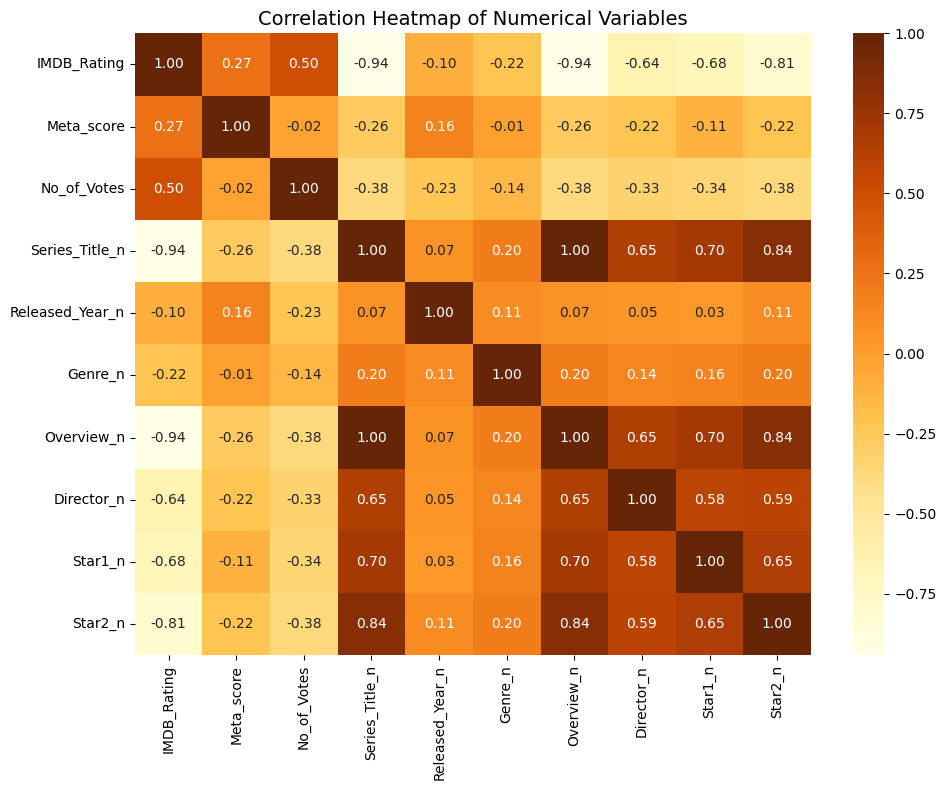

In [124]:
num_cols = clean_data.select_dtypes(include=['float64','int64']).columns
corr_matrix = clean_data[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlOrBr', cbar=True)

plt.title("Correlation Heatmap of Numerical Variables", fontsize=14)
plt.tight_layout()
plt.show()


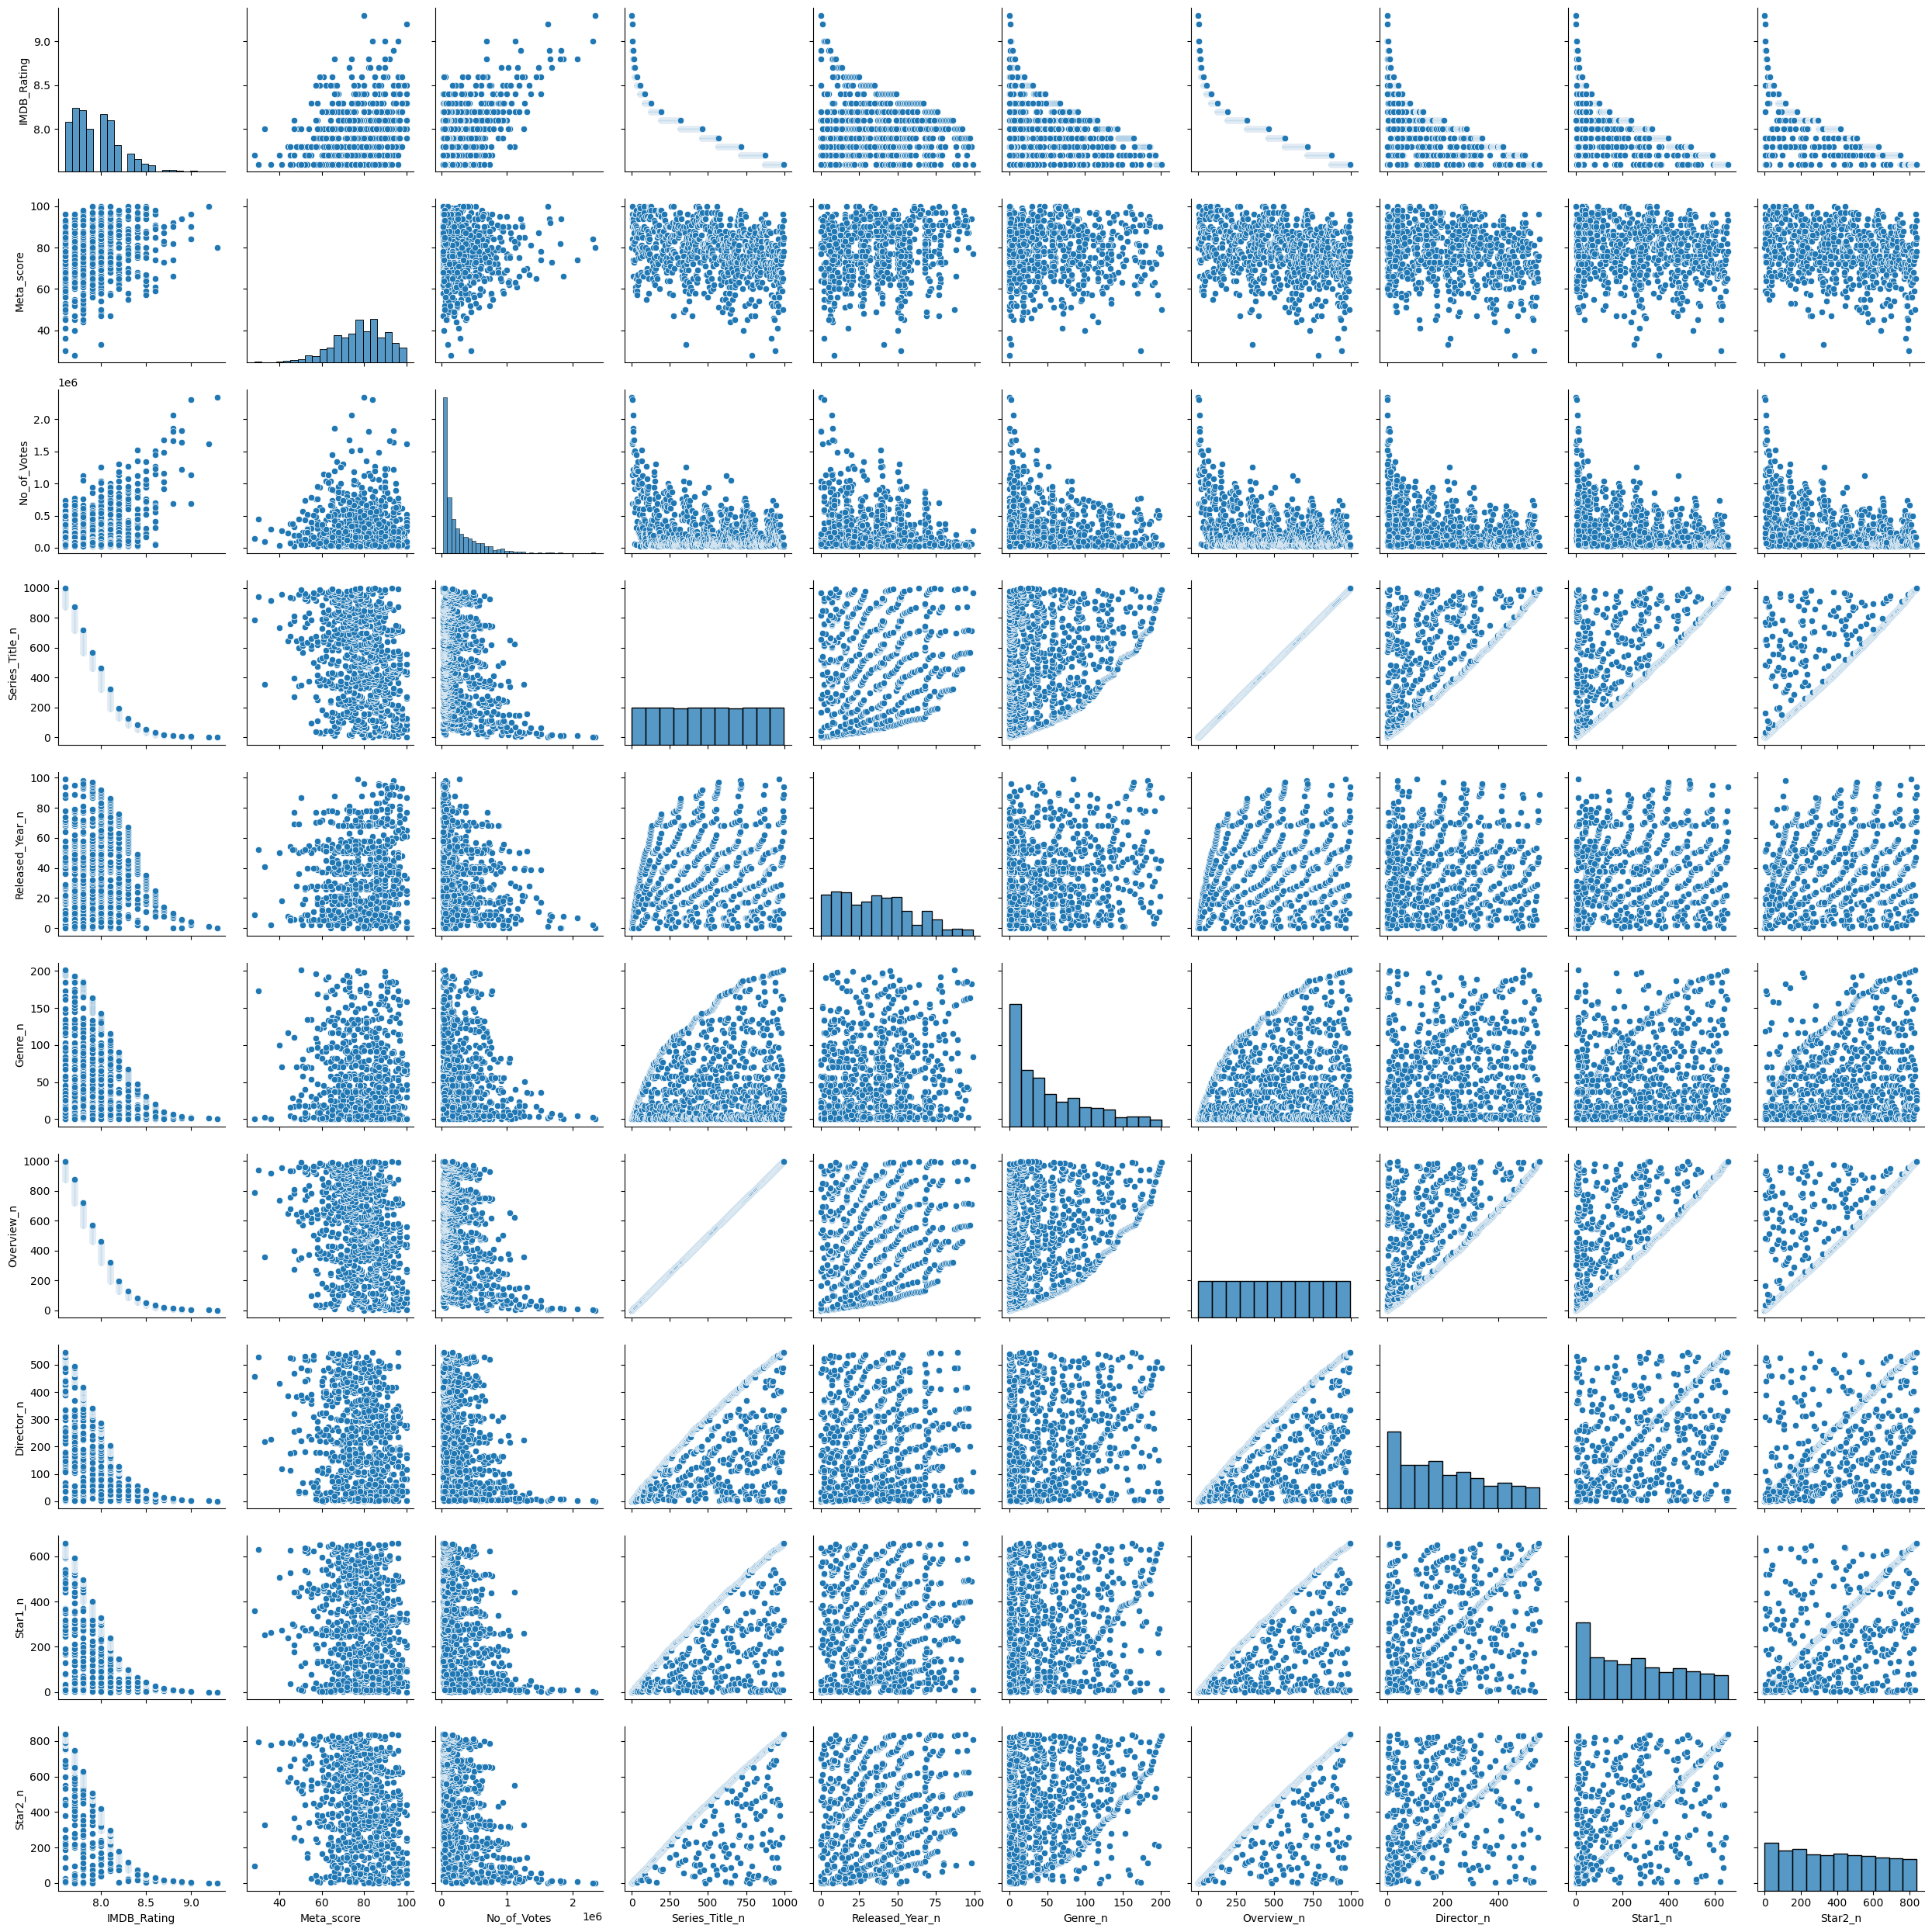

In [125]:
sns.pairplot(data = clean_data)
plt.tight_layout()
plt.show()

### **Feature Engineering**

**- Outliers Analysis**

In [126]:
clean_data.describe()

,IMDB_Rating,Meta_score,No_of_Votes,Series_Title_n,Released_Year_n,Genre_n,Overview_n,Director_n,Star1_n,Star2_n
count,999.000000,843.000000,9.990000e+02,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,7.949049,77.971530,2.738964e+05,499.000000,36.083083,53.783784,499.000000,213.850851,270.734735,392.876877
std,0.275515,12.376099,3.274734e+05,288.530761,23.829725,52.576629,288.530761,157.032963,194.731125,244.586863
min,7.600000,28.000000,2.508800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.700000,70.000000,5.547150e+04,249.500000,17.000000,9.000000,249.500000,71.000000,93.000000,180.500000
50%,7.900000,79.000000,1.387410e+05,499.000000,36.000000,37.000000,499.000000,190.000000,255.000000,385.000000
75%,8.100000,87.000000,3.744775e+05,748.500000,52.000000,86.500000,748.500000,329.500000,436.500000,599.000000
max,9.300000,100.000000,2.343110e+06,998.000000,99.000000,201.000000,998.000000,546.000000,658.000000,839.000000


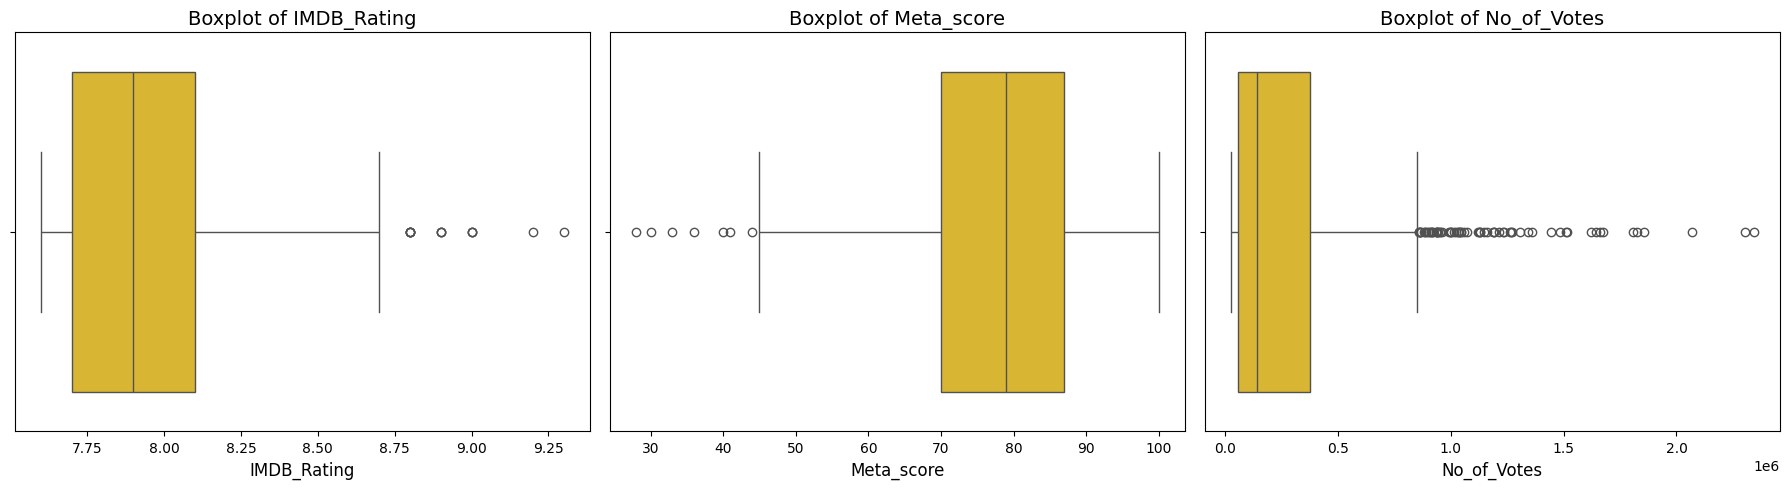

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_variables), figsize=(18, 5))

for i, col in enumerate(numerical_variables):
    sns.boxplot(x=clean_data[col], color='#F5C518', ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}", fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

In [138]:
numerical_columns = clean_data.select_dtypes(include=['number']).columns.tolist()

for column in numerical_columns:
    stats = clean_data[column].describe()
    iqr = stats["75%"] - stats["25%"]
    upper_limit = stats["75%"] + 1.5 * iqr
    lower_limit = stats["25%"] - 1.5 * iqr
    if lower_limit < 0:
      lower_limit = 0
    
    outliers = clean_data[(clean_data[column] < lower_limit) | (clean_data[column] > upper_limit)]
    outlier_count = outliers.shape[0]

    print(f"{column.capitalize()} — IQR: {round(iqr, 2)}, Upper limits: {round(upper_limit, 2)}, Lowerlimits: {round(lower_limit, 2)}, Total outliers: {outlier_count}\n")

Imdb_rating — IQR: 0.4, Upper limits: 8.7, Lowerlimits: 7.1, Total outliers: 13

Meta_score — IQR: 17.0, Upper limits: 112.5, Lowerlimits: 44.5, Total outliers: 7

No_of_votes — IQR: 319006.0, Upper limits: 852986.5, Lowerlimits: 0, Total outliers: 67

Series_title_n — IQR: 499.0, Upper limits: 1497.0, Lowerlimits: 0, Total outliers: 0

Released_year_n — IQR: 35.0, Upper limits: 104.5, Lowerlimits: 0, Total outliers: 0

Genre_n — IQR: 77.5, Upper limits: 202.75, Lowerlimits: 0, Total outliers: 0

Overview_n — IQR: 499.0, Upper limits: 1497.0, Lowerlimits: 0, Total outliers: 0

Director_n — IQR: 258.5, Upper limits: 717.25, Lowerlimits: 0, Total outliers: 0

Star1_n — IQR: 343.5, Upper limits: 951.75, Lowerlimits: 0, Total outliers: 0

Star2_n — IQR: 418.5, Upper limits: 1226.75, Lowerlimits: 0, Total outliers: 0



- We do not remove outliers because they represent meaningful extremes, such as highly popular movies or exceptionally high ratings. Removing them could lead to loss of valuable information and distort the dataset's real distribution.

**Missing Values**

In [139]:
clean_data.isnull().sum().sort_values(ascending = False)

Meta_score         156
Series_Title         0
Released_Year        0
IMDB_Rating          0
Genre                0
Overview             0
Director             0
Star1                0
Star2                0
No_of_Votes          0
Series_Title_n       0
Released_Year_n      0
Genre_n              0
Overview_n           0
Director_n           0
Star1_n              0
Star2_n              0
dtype: int64

In [ ]:
clean_data['Meta_score'] = clean_data['Meta_score'].fillna(clean_data['Meta_score'].median())

**Split Train & Test**

In [169]:
target = "IMDB_Rating"

# Dataset with outliers
X = clean_data[num_cols].drop(columns=target)
y = clean_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Feature Engineering**

In [174]:
# 1. Genre: convertir en listas
clean_data['Genre_list'] = clean_data['Genre'].apply(lambda x: [g.strip() for g in x.split(',')])

# 2. Stars: combinar Star1 y Star2 
clean_data['Stars_list'] = clean_data[['Star1','Star2']].values.tolist()
clean_data['Stars_list'] = clean_data['Stars_list'].apply(lambda x: [str(i) for i in x])

# 3. Director: poner en lista
clean_data['Director_list'] = clean_data['Director'].apply(lambda x: [x])

# 4. Overview: limpiar texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

clean_data['Overview_clean'] = clean_data['Overview'].apply(clean_text)


In [ ]:
# TF-IDF para overview
tfidf = TfidfVectorizer(stop_words='english')
overview_matrix = tfidf.fit_transform(clean_data['Overview_clean'])

# Multi-hot encoding para Genre, Director y Stars
mlb = MultiLabelBinarizer()

genre_matrix = mlb.fit_transform(clean_data['Genre_list'])
director_matrix = mlb.fit_transform(clean_data['Director_list'])
stars_matrix = mlb.fit_transform(clean_data['Stars_list'])

# Combinar todas las matrices
feature_matrix = hstack([overview_matrix, genre_matrix, director_matrix, stars_matrix])

In [178]:
# Cosine similarity
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)
